## Setup

In [4]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/home/zkim/outdoor_navigation/semantic-segmentation/notebooks/semantic-segmentation
Defaulting to user installation because normal site-packages is not writeable


/home/zkim/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///home/zkim/outdoor_navigation/semantic-segmentation/notebooks/semantic-segmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for semseg
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [11]:
import os
os.chdir("/home/zkim/outdoor_navigation/semantic-segmentation")
os.getcwd()

'/home/zkim/outdoor_navigation/semantic-segmentation'

In [12]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [7]:
%pip install -U gdown

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [13]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=e6e2dc54-9eef-4d4a-97d2-91defc032c08
To: /home/zkim/outdoor_navigation/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:04<00:00, 38.2MB/s] 


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [14]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

Loaded Model


## Simple Image Inference

### Load Image

torch.Size([3, 512, 683])


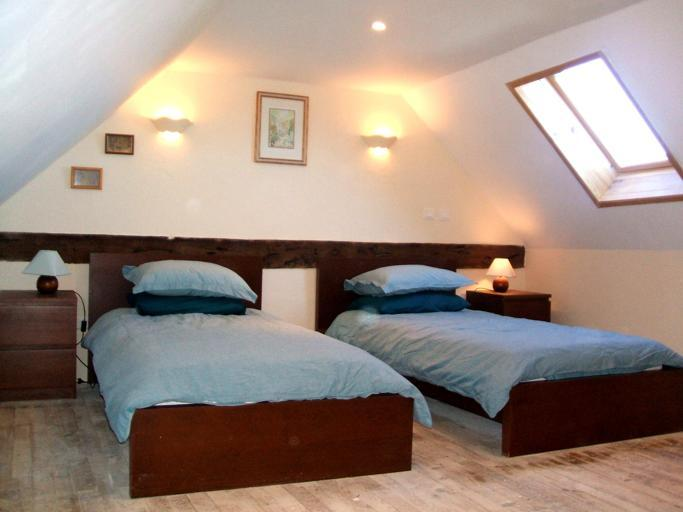

In [15]:
image_path = './assests/ade/ADE_val_00000049.jpg'
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [16]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [17]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [18]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([  0,   3,   5,   7,   8,  15,  22,  36,  57,  82, 134])

In [19]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

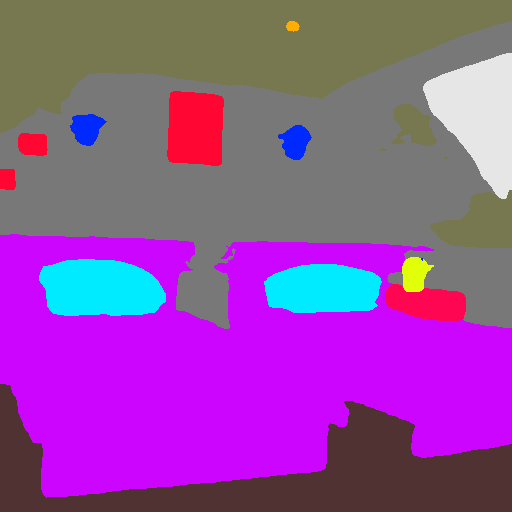

In [20]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

## Show Available Backbones

In [21]:
from semseg import show_backbones

show_backbones()

Backbone Names    Variants
----------------  ------------------------------------
ResNet            ['18', '34', '50', '101', '152']
ResNetD           ['18', '50', '101']
MicroNet          ['M1', 'M2', 'M3']
MobileNetV2       ['1.0']
MobileNetV3       ['S', 'L']
MiT               ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
PVTv2             ['B1', 'B2', 'B3', 'B4', 'B5']
ResT              ['S', 'B', 'L']
PoolFormer        ['S24', 'S36', 'M36']
ConvNeXt          ['T', 'S', 'B']


## Show Available Heads

In [22]:
from semseg import show_heads

show_heads()

  No.  Heads
-----  -------------
    1  UPerHead
    2  SegFormerHead
    3  SFHead
    4  FPNHead
    5  FaPNHead
    6  FCNHead
    7  CondHead
    8  LawinHead


## Show Available Datasets

In [23]:
from semseg import show_datasets

show_datasets()

  No.  Datasets
-----  ---------------
    1  CamVid
    2  CityScapes
    3  ADE20K
    4  MHPv1
    5  MHPv2
    6  LIP
    7  CIHP
    8  CCIHP
    9  ATR
   10  PASCALContext
   11  COCOStuff
   12  SUIM
   13  SunRGBD
   14  MapillaryVistas
   15  HELEN
   16  LaPa
   17  iBugMask
   18  CelebAMaskHQ
   19  FaceSynthetics


## Construct a Custom Model

### Choose a Backbone

In [24]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [25]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [26]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])
torch.Size([2, 256, 14, 14])
torch.Size([2, 512, 7, 7])


### Choose a Head

In [29]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [30]:
seg = head(features)
seg.shape

torch.Size([2, 10, 56, 56])

In [31]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

torch.Size([2, 10, 224, 224])

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.

In [1]:
import torch
from torch import Tensor
from torch.nn import functional as F
from semseg.models.base import BaseModel
from semseg.models.heads import UPerHead

from semseg.models import show_models
from semseg.models.backbones import show_models

ModuleNotFoundError: No module named 'semseg'

In [38]:
# load state dict

import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary 
from torchsummary import summary

model_path = '/home/zkim/outdoor_navigation/semantic-segmentation/checkpoints/pretrained/ddrnet/DDRNet23s_imagenet.pth'

model = DDRNet()

print(model)

model.load_state_dict(torch.load(model_path))




DDRNet(
  (conv1): Stem(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.

RuntimeError: Error(s) in loading state_dict for DDRNet:
	Missing key(s) in state_dict: "spp.scale1.1.weight", "spp.scale1.1.bias", "spp.scale1.1.running_mean", "spp.scale1.1.running_var", "spp.scale1.3.weight", "spp.scale2.1.weight", "spp.scale2.1.bias", "spp.scale2.1.running_mean", "spp.scale2.1.running_var", "spp.scale2.3.weight", "spp.scale3.1.weight", "spp.scale3.1.bias", "spp.scale3.1.running_mean", "spp.scale3.1.running_var", "spp.scale3.3.weight", "spp.scale4.1.weight", "spp.scale4.1.bias", "spp.scale4.1.running_mean", "spp.scale4.1.running_var", "spp.scale4.3.weight", "spp.scale0.0.weight", "spp.scale0.0.bias", "spp.scale0.0.running_mean", "spp.scale0.0.running_var", "spp.scale0.2.weight", "spp.process1.0.weight", "spp.process1.0.bias", "spp.process1.0.running_mean", "spp.process1.0.running_var", "spp.process1.2.weight", "spp.process2.0.weight", "spp.process2.0.bias", "spp.process2.0.running_mean", "spp.process2.0.running_var", "spp.process2.2.weight", "spp.process3.0.weight", "spp.process3.0.bias", "spp.process3.0.running_mean", "spp.process3.0.running_var", "spp.process3.2.weight", "spp.process4.0.weight", "spp.process4.0.bias", "spp.process4.0.running_mean", "spp.process4.0.running_var", "spp.process4.2.weight", "spp.compression.0.weight", "spp.compression.0.bias", "spp.compression.0.running_mean", "spp.compression.0.running_var", "spp.compression.2.weight", "spp.shortcut.0.weight", "spp.shortcut.0.bias", "spp.shortcut.0.running_mean", "spp.shortcut.0.running_var", "spp.shortcut.2.weight", "seghead_extra.bn1.weight", "seghead_extra.bn1.bias", "seghead_extra.bn1.running_mean", "seghead_extra.bn1.running_var", "seghead_extra.conv1.weight", "seghead_extra.bn2.weight", "seghead_extra.bn2.bias", "seghead_extra.bn2.running_mean", "seghead_extra.bn2.running_var", "seghead_extra.conv2.weight", "seghead_extra.conv2.bias", "final_layer.bn1.weight", "final_layer.bn1.bias", "final_layer.bn1.running_mean", "final_layer.bn1.running_var", "final_layer.conv1.weight", "final_layer.bn2.weight", "final_layer.bn2.bias", "final_layer.bn2.running_mean", "final_layer.bn2.running_var", "final_layer.conv2.weight", "final_layer.conv2.bias". 
	Unexpected key(s) in state_dict: "down5.0.weight", "down5.1.weight", "down5.1.bias", "down5.1.running_mean", "down5.1.running_var", "down5.1.num_batches_tracked", "down5.3.weight", "down5.4.weight", "down5.4.bias", "down5.4.running_mean", "down5.4.running_var", "down5.4.num_batches_tracked", "last_layer.0.weight", "last_layer.1.weight", "last_layer.1.bias", "last_layer.1.running_mean", "last_layer.1.running_var", "last_layer.1.num_batches_tracked", "linear.weight", "linear.bias". 